## Functions and Imports

In [97]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
import random
import datetime
from onix.analysis.fitter import Fitter
import onix.models.hyperfine as hyperfine
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
from onix.models.schiff import inverse_fa_limit
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev, mdev
from astropy.timeseries import LombScargle
from onix.analysis.functions.shared import *
from onix.analysis.functions.lf_ramsey_shared import *
from onix.analysis.functions.lf_spectroscopy_quick_state_prep_axion import *

### Antihole SNR Fluctuations

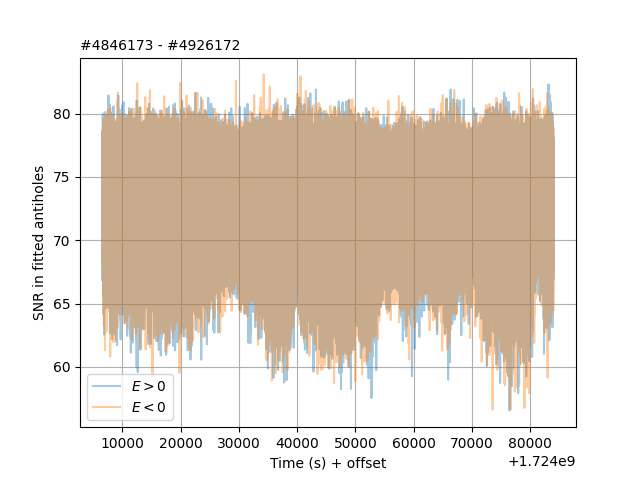

In [229]:
times_E_pos1, times_E_neg1, SNR_E_pos1, SNR_E_neg1 = antihole_SNR_over_time((4846173, 4846180), 4926172)

In [230]:
path_to_save = "/home/icarus/Documents/data/manual/2024_08/19/snr_over_time.npz"
np.savez(path_to_save,times_E_pos = times_E_pos1, times_E_neg = times_E_neg1, SNR_E_pos = SNR_E_pos1, SNR_E_neg = SNR_E_neg1)

In [231]:
loaded_data = np.load(path_to_save, allow_pickle = True)
times_E_pos = loaded_data["times_E_pos"]
times_E_neg = loaded_data["times_E_neg"]
SNR_E_pos = loaded_data["SNR_E_pos"]
SNR_E_neg = loaded_data["SNR_E_neg"]

In [232]:
SNR_E_pos1 = np.array(SNR_E_pos)
times_E_pos1 = np.array(times_E_pos)
SNR_E_neg1 = np.array(SNR_E_neg)
times_E_neg1 = np.array(times_E_neg)

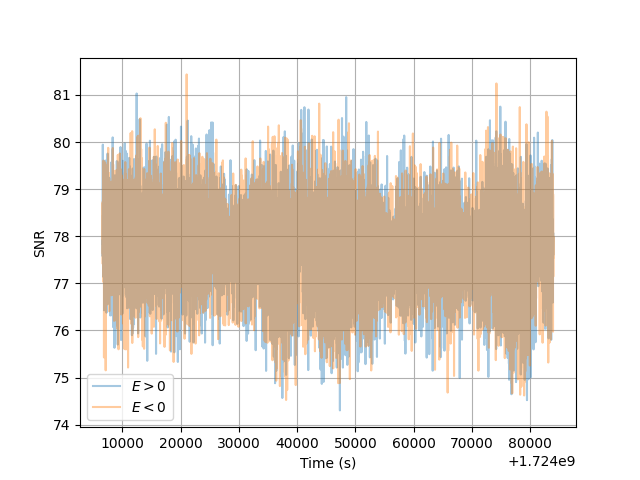

In [234]:
package_size = 8
fig, ax = plt.subplots()
ax.plot(times_E_pos[0::package_size], SNR_E_pos[0::package_size], alpha = 0.4, label = "$E>0$")
ax.plot(times_E_neg[0::package_size], SNR_E_neg[0::package_size], alpha = 0.4, label = "$E<0$")

# pred = []
# for i in times_E_pos:
#     pred.append(20* np.sin(2*np.pi*f[np.argmax(norm_squared_fft)] * i) + 40)   
#ax.plot(times_E_pos, pred)

ax.set_xlabel("Time (s)")
ax.set_ylabel("SNR")
ax.grid()
ax.legend()
plt.show()

E>0 	 Maximum: 1.2923554866182546e-05 Hz = 77378.09065342617 s
E<0 	 Maximum: 1.2923554866182546e-05 Hz = 77378.09065342617 s


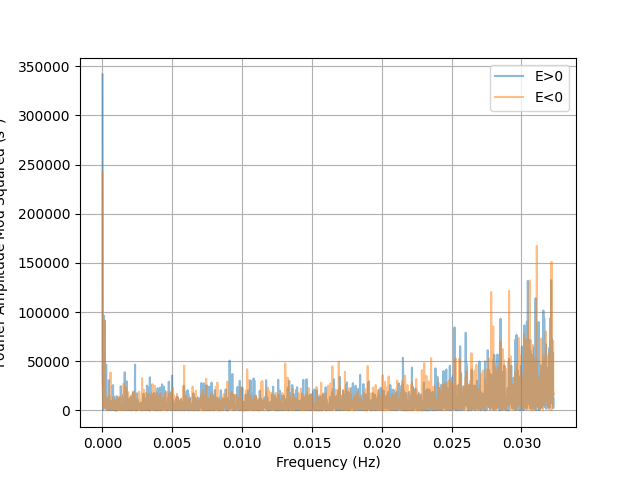

In [239]:
delta_t_neg = np.mean(np.diff(times_E_neg1[0::package_size]))
fft_E_neg = np.fft.fft(SNR_E_neg1[0::package_size])
n_neg = len(SNR_E_neg1) // package_size
frequencies_neg = np.fft.fftfreq(n_neg, delta_t_neg)
f_mask_neg = frequencies_neg > 0
f_neg = frequencies_neg[f_mask_neg]
fft_E_neg = fft_E_neg[f_mask_neg]
norm_squared_fft_neg = 2*np.abs(fft_E_neg)**2

delta_t_pos = np.mean(np.diff(times_E_pos1[0::package_size]))
fft_E_pos = np.fft.fft(SNR_E_pos1[0::package_size])
n_pos = len(SNR_E_pos1) // package_size
frequencies_pos = np.fft.fftfreq(n_pos, delta_t_pos)
f_mask_pos = frequencies_pos > 0
f_pos = frequencies_pos[f_mask_pos]
fft_E_pos = fft_E_pos[f_mask_pos]
norm_squared_fft_pos = 2*np.abs(fft_E_pos)**2

fig, ax = plt.subplots()
ax.plot(f_pos, norm_squared_fft_pos, label = "E>0", alpha = 0.5)
ax.plot(f_neg, norm_squared_fft_neg, label = "E<0", alpha = 0.5)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Fourier Amplitude Mod Squared ($s^2$)")
ax.legend()
ax.grid()

print(f"E>0 \t Maximum: {f_pos[np.argmax(norm_squared_fft_pos)]} Hz = {1/f_pos[np.argmax(norm_squared_fft_pos)]} s") 
print(f"E<0 \t Maximum: {f_neg[np.argmax(norm_squared_fft_neg)]} Hz = {1/f_neg[np.argmax(norm_squared_fft_neg)]} s") 
# All data E>0 3348.51185675152 s; first half of data E>0 3266.5182075779812 s; second half of data E >0 3326.881143538796 s

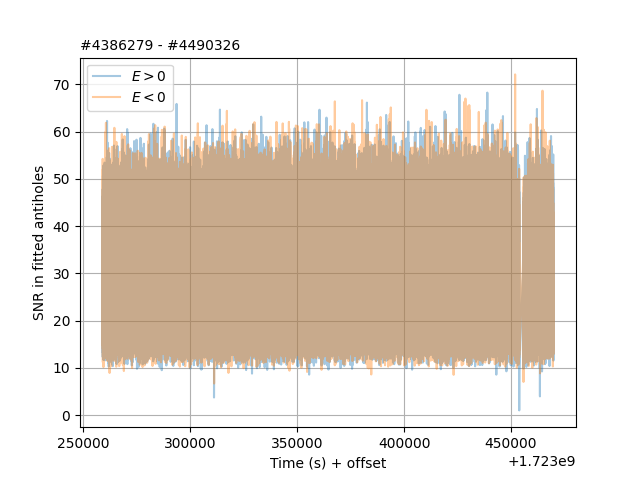

In [3]:
times_E_pos, times_E_neg, SNR_E_pos, SNR_E_neg = antihole_SNR_over_time((4386279, 4386279+7), 4490326)

In [6]:
path_to_save = "/home/icarus/Documents/data/manual/2024_08/15/snr_over_time.npz"
np.savez(path_to_save,times_E_pos = times_E_pos, times_E_neg = times_E_neg, SNR_E_pos = SNR_E_pos, SNR_E_neg = SNR_E_neg)

In [33]:
loaded_data = np.load(path_to_save, allow_pickle = True)
times_E_pos = loaded_data["times_E_pos"]
times_E_neg = loaded_data["times_E_neg"]
SNR_E_pos = loaded_data["SNR_E_pos"]
SNR_E_neg = loaded_data["SNR_E_neg"]

In [42]:
SNR_E_pos1 = np.array(SNR_E_pos[0:len(SNR_E_pos) // 2])
times_E_pos1 = np.array(times_E_pos[0:len(times_E_pos ) // 2])
SNR_E_neg1 = np.array(SNR_E_neg[0:len(SNR_E_neg) //2])
times_E_neg1 = np.array(times_E_neg[0: len(times_E_neg) // 2])

SNR_E_pos2 = np.array(SNR_E_pos[len(SNR_E_pos) // 2:])
times_E_pos2 = np.array(times_E_pos[len(times_E_pos ) // 2:])
SNR_E_neg2 = np.array(SNR_E_neg[len(SNR_E_neg) //2:])
times_E_neg2 = np.array(times_E_neg[len(times_E_neg) // 2:])

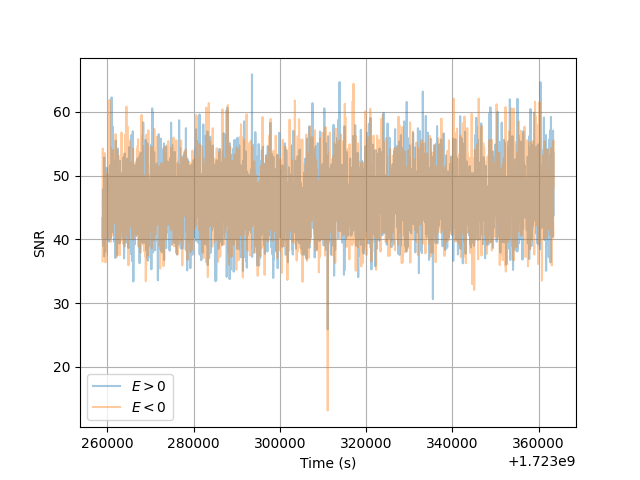

In [25]:
package_size = 8
fig, ax = plt.subplots()
ax.plot(times_E_pos[0::package_size], snr_E_pos[0::package_size], alpha = 0.4, label = "$E>0$")
ax.plot(times_E_neg[0::package_size], snr_E_neg[0::package_size], alpha = 0.4, label = "$E<0$")

# pred = []
# for i in times_E_pos:
#     pred.append(20* np.sin(2*np.pi*f[np.argmax(norm_squared_fft)] * i) + 40)   
#ax.plot(times_E_pos, pred)

ax.set_xlabel("Time (s)")
ax.set_ylabel("SNR")
ax.grid()
ax.legend()
plt.show()

E>0 	 Maximum: 0.00030613636185468194 Hz = 3266.5182075779812 s
E<0 	 Maximum: 0.00030613636185468194 Hz = 3266.5182075779812 s


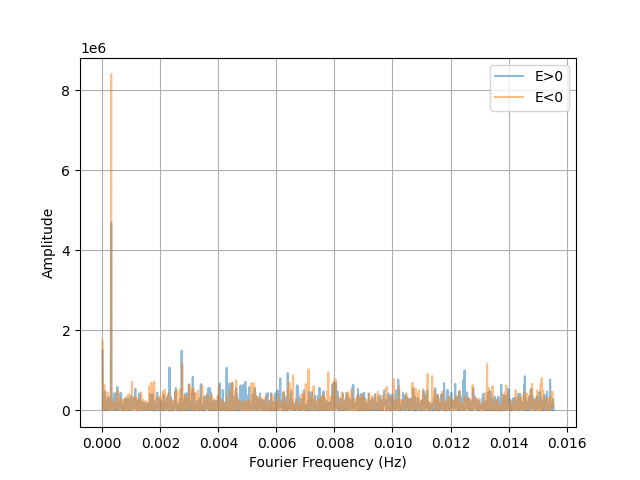

In [50]:
delta_t_neg = np.mean(np.diff(times_E_neg1[0::package_size]))
fft_E_neg = np.fft.fft(SNR_E_neg1[0::package_size])
n_neg = len(SNR_E_neg1) // package_size
frequencies_neg = np.fft.fftfreq(n+1, delta_t_neg)
f_mask_neg = frequencies_neg > 0
f_neg = frequencies_neg[f_mask_neg]
fft_E_neg = fft_E_neg[f_mask_neg]
norm_squared_fft_neg = 2*np.abs(fft_E_neg)**2

delta_t_pos = np.mean(np.diff(times_E_pos1[0::package_size]))
fft_E_pos = np.fft.fft(SNR_E_pos1[0::package_size])
n_pos = len(SNR_E_pos1) // package_size
frequencies_pos = np.fft.fftfreq(n+1, delta_t_pos)
f_mask_pos = frequencies_pos > 0
f_pos = frequencies_pos[f_mask_pos]
fft_E_pos = fft_E_pos[f_mask_pos]
norm_squared_fft_pos = 2*np.abs(fft_E_pos)**2

fig, ax = plt.subplots()
ax.plot(f_pos, norm_squared_fft_pos, label = "E>0", alpha = 0.5)
ax.plot(f_neg, norm_squared_fft_neg, label = "E<0", alpha = 0.5)
ax.set_xlabel("Fourier Frequency (Hz)")
ax.set_ylabel("Amplitude")
ax.legend()
ax.grid()

print(f"E>0 \t Maximum: {f[np.argmax(norm_squared_fft_pos)]} Hz = {1/f[np.argmax(norm_squared_fft_pos)]} s") 
print(f"E<0 \t Maximum: {f[np.argmax(norm_squared_fft_neg)]} Hz = {1/f[np.argmax(norm_squared_fft_neg)]} s") 
# All data E>0 3348.51185675152 s; first half of data E>0 3266.5182075779812 s; second half of data E >0 3326.881143538796 s

## Plot Ramsey

A = 0.0585(7) 
C = 0.0939(5) 
phi_0 = 0.103(12) 
A = 0.0598(8) 
C = 0.0972(6) 
phi_0 = 0.098(14) 
SNR with 9 phase points = 72.54786995886434


(<Figure size 1200x720 with 1 Axes>,
 <Axes: xlabel='Ramsey phase difference', ylabel='absorption - offset (arb. unit)'>)

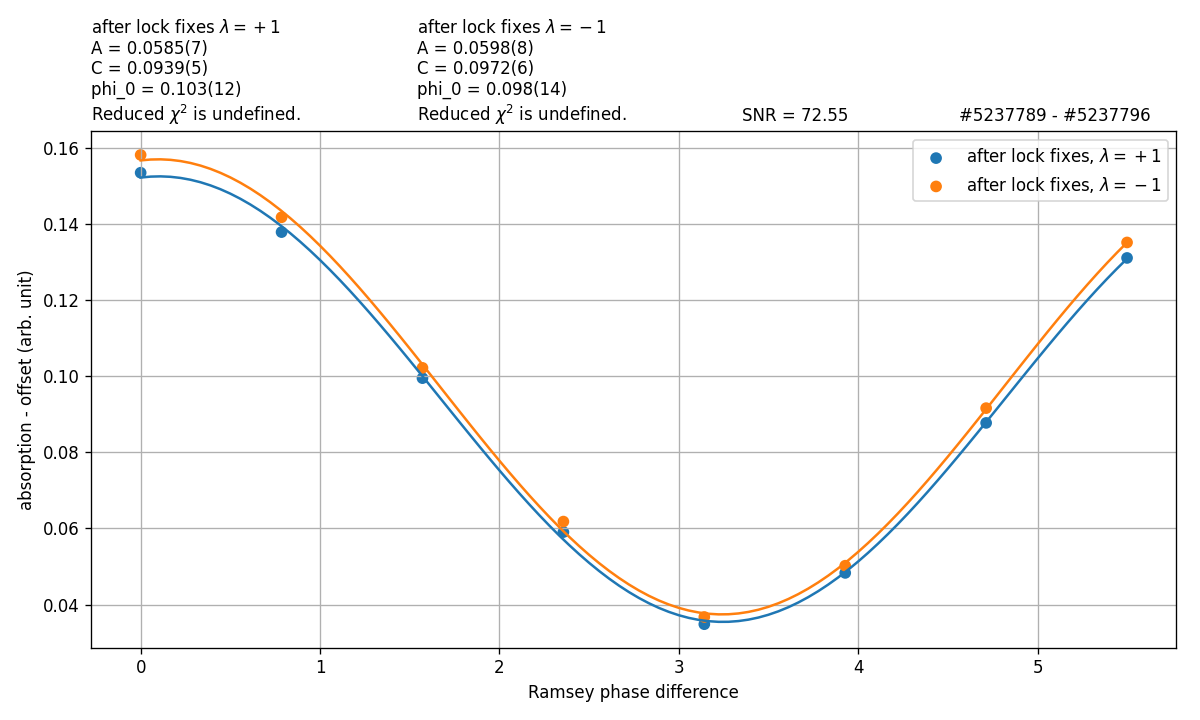

In [337]:
data = {
    #"256 repeats": (2555562 , 2555961),
    #"64 repeats": (2555962, 2556361),
    #"16 repeats": (2556362 , 2556761),
    #"test": (2678062 +4, 2678065+4),
    #"temp":(4620280, 4620287),
    #"temp":(4625350, 4625353),
    "after lock fixes":(5237789, 5237796)
}

plot_ramsey(data, get_results, do_average = True)

## long term phase scan

In [13]:
## Old experiment data numbers
# data_range = (3055958 , 3055958 + 7)
# max = 3073350

# data_range = (4048762, 4048769)
# max = 4050193

# data_range = (4084103, 4084103+8)
# max = 4084363

# August 7 - 8 overnight
# data_range = (4242552, 4242559)
# max = 4321239

# 1.1 MHz stark splitting. Fit without linear term
# data_range = (4343578, 4343585)
# max = 4379537

# 2 MHz splitting with 5 MHz chasms
# data_range = (4385377, 4385384)
# max = 4386104

#2 MHz splitting with 2.5 MHz chasms
# data_range = (4386203, 4386210)
# max = 4386258

# back to 5 MHz chasm
# data_range = (4386279, 4386286)
# max = 4490326

# correct 1.1 MHz Data
# data_range = (4496091, 4496098)
# max = 4507402

#axion run changed RF offset 
# data_range = (4530349, 4530349 + 7)
# max = 4543952


###############################################################

##### short time

# test with cb optical mirror
# data_range = (4544758, 4544765)
# max = 4545557

# null without cb mirror
# data_range = (4545558, 4545565)
# max = 4546357

##### for a longer time (~ 1h)

# test with cb optical mirror
# data_range = (4546464, 4546471)
# max = 4554463

# null without cb mirror
# data_range = (4554616, 4554623)
# max = 4562615

###############################################################

### overnight cb detuning perturb test

# -19 MHz
# data_range = (4562879, 4562886)
# max = 4572478

# -18.5 MHz
# data_range = (4572479, 4572486)
# max = 4582078

# -18 MHz
# data_range = (4582079, 4582086)
# max = 4591678

# -17.5 MHz
# data_range = (4591679, 4591686)
# max = 4601278

# -17 MHz
# data_range = (4601279, 4601286)
# max = 4610878

###############################################################3
# chasm run with different E fields
# data_range = (4511113, 4511113+7)
# max = 4528392

# 1.1 MHz-- attempt to reproduce measurement of W_T = 0
# data_range = (4611050, 4611057)
# max = 4612945

#another attempt of the above
# data_range = (4613004, 4613011)
# max = 4613611

###############################################################
# OPTIMIZING STATE PREPARATION PARAMETERS
# data_range = (4614612, 4614619)
# max = 4614771

In [162]:
def get_fid_normalized_transmission(data_number, integrated = False, integration_window_size = 100e3):
    """
    Computes the real fourier transform of detections.
    Finds the indices closest to the centers of the peaks in the Fourier spectrum using probe detuning +- detect detuning
    
    If integrated = False this saves the height of the peak, the value of the rfft at these closest indices.
    If integrated = True this saves the integral about the center of the peak. 
    We integrate over [peak_center - integration_window_size, peak_center + integrataion_window_size]

    Step size is 20.8 kHz.
    """
    data, header = get_experiment_data(data_number)
    sample_rate = header["params"]["digitizer"]["sample_rate"]
    fid_params = header["params"]["detect"]["fid"]
    start_time = (fid_params["pump_time"] + fid_params["wait_time"]).to("s").magnitude + 7e-6
    #fft_end_time = start_time + fft_end_time_s
    times = np.arange(len(data["transmissions_avg"][0])) / sample_rate
    mask = (times > start_time) #& (times < fft_end_time)
    time_resolution = times[1] - times[0]
    fs = np.fft.rfftfreq(len(data["transmissions_avg"][0][mask]), d=time_resolution)
    delta_f = fs[1] - fs[0]
    integration_index = round(integration_window_size / delta_f)
    duration = times[mask][-1] - times[mask][0]
    N = duration / time_resolution + 1
    freqs_to_probe = []
    freqs_to_probe.append((header["params"]["detect"]["fid"]["probe_detuning"] - header["params"]["detect"]["detunings"][0]).to("Hz").magnitude)
    freqs_to_probe.append((header["params"]["detect"]["fid"]["probe_detuning"] + header["params"]["detect"]["detunings"][0]).to("Hz").magnitude)
    freqs_to_probe = np.abs(freqs_to_probe)
    detunings_MHz = np.array(freqs_to_probe) * 1e-6
    indices_to_probe = []
    for freq in freqs_to_probe:
        closest_index = np.argmin(np.abs(fs - freq))
        indices_to_probe.append(closest_index)
    normalized_avg = [[] for kk in freqs_to_probe]
    if "save_avg" in header["params"]["detect"]["fid"] and header["params"]["detect"]["fid"]["save_avg"]:
        ys = np.fft.rfft(data["transmissions_avg"][0][mask]) / N
        for ll, closest_index in enumerate(indices_to_probe):
            if integrated:
                normalized_avg[ll].append(ys[closest_index])
                peak = ys[closest_index - integration_index : closest_index + integration_index]            
                freq_range = fs[closest_index - integration_index : closest_index + integration_index]
                area_under_peak = np.trapz(peak,freq_range,dx=freq_range[1]-freq_range[0])
                normalized_avg[ll].append(area_under_peak)
            else:
                normalized_avg[ll].append(ys[closest_index])
        
    else:
        for kk, d in enumerate(data["transmissions_avg"]):
            if kk < len(data["transmissions_avg"]) / 2:
                continue
            else:
                ys = np.fft.rfft(d[mask]) / N
            for ll, closest_index in enumerate(indices_to_probe):
                normalized_avg[ll].append(ys[closest_index])
    normalized_avg_avg = np.abs(np.average(normalized_avg, axis=1))
    # normalized_avg_std = np.std(np.abs(np.array(normalized_avg) - normalized_avg_avg), axis=1)
    # normalized_avg_std /= len(normalized_avg[0])
    normalized_avg = {"3": -unumpy.uarray(normalized_avg_avg, np.zeros(len(normalized_avg_avg))), "6": ufloat(0,0)}
    return detunings_MHz, normalized_avg, header

In [140]:
def get_fid_experiment_result(data_number, **kwargs):
    detunings, data, header = get_fid_normalized_transmission(data_number, integrated = integrated)
    total_pop_1 = 1
    pop_other_state_1 = -data["3"]
    
    total_pop_2 = 0
    pop_other_state_2 = - data["6"]
    return (header, pop_other_state_1 + pop_other_state_2, total_pop_1 + total_pop_2)

In [141]:
def get_fid_results(data_identification, **kwargs):
    data_list = data_identification_to_list(data_identification)
    headers = []
    results = []
    for data_number in data_list:
        header, pop_other_state, total_pop = get_fid_experiment_result(data_number, integrated = integrated)
        headers.append(header)
        results.append(pop_other_state / total_pop)
    return headers, np.array(results)

In [2]:
import uncertainties.core

class CallableStdDev(float):
    '''
    Class for standard deviation results, which used to be
    callable. Provided for compatibility with old code. Issues an
    obsolescence warning upon call.
    '''

    # This class is a float. It must be set to the standard deviation
    # upon construction.

    def __call__ (self):
        deprecation('the std_dev attribute should not be called'
                    ' anymore: use .std_dev instead of .std_dev().')
        return self

uncertainties.core.CallableStdDev = CallableStdDev

### Absorption

In [429]:

######### chasm, no mirror
# data_range = (4657576, 4657583)
# max = 4659175

######### no chasm, mirror
# data_range = (4659176, 4659183)
# max = 4660775

# August 17 axion run
data_range = (4787037, 4787044)
max = 5515012

results, col_indices = analyze_data(data_range, max, get_results, save_new=True)

new analysis
Existing data loaded


In [430]:
# last 4726136

In [431]:
np.max(results[:,col_indices["end_time"]])

1724719235.969547

In [432]:
start_time = 1723938600
start_mask = results[:, col_indices["start_time"]] > start_time

# cut out data points at which there had been a large gap in data taking directly before / after
cycle_times = results[:, col_indices["start_time"]][1:] - results[:, col_indices["start_time"]][:-1]
cycle_times = np.concatenate([[0], cycle_times])
cycle_time_upper_limit = 10
cycle_time_discard_mask = cycle_times > cycle_time_upper_limit
cycle_time_mask = np.ones(len(cycle_times), dtype=bool)
for kk in cycle_time_discard_mask.nonzero()[0]:
    mask_last = kk + 20
    if mask_last > len(results):
        mask_last = len(results)
    cycle_time_mask[np.arange(kk - 5, mask_last)] = False

#start_mask = np.logical_and(start_mask, cycle_time_mask)

a_mask = results[:, col_indices["state"]] == "a"
b_mask = results[:, col_indices["state"]] == "b"

E_fields = np.unique(results[:, col_indices["field_plate_amplitude"]])
E_masks = [results[:, col_indices["field_plate_amplitude"]] == kk for kk in E_fields]

rf_amplitudes = np.unique(results[:, col_indices["rf_amplitude"]])
rf_amplitude_masks = [results[:, col_indices["rf_amplitude"]] == kk for kk in rf_amplitudes]

rf_durations = np.unique(results[:, col_indices["rf_duration_ms"]])
rf_duration_masks = [results[:, col_indices["rf_duration_ms"]] == kk for kk in rf_durations]

durations = np.unique(results[:, col_indices["pulse_time_ms"]])
duration_masks = [results[:, col_indices["pulse_time_ms"]] == kk for kk in durations]

E_pos_mask = results[:, col_indices["E"]] == True
E_neg_mask = results[:, col_indices["E"]] == False

start_times_a = results[a_mask, col_indices["start_time"]]
start_times_b = results[b_mask, col_indices["start_time"]]
f_p_a = results[a_mask, col_indices["f+"]]
f_m_a = results[a_mask, col_indices["f-"]]
f_p_b = results[b_mask, col_indices["f+"]]
f_m_b = results[b_mask, col_indices["f-"]]

Z_a = results[a_mask, col_indices["Z"]]
Z_b = results[b_mask, col_indices["Z"]]
W_T_a = results[a_mask, col_indices["W_T"]]
W_T_b = results[b_mask, col_indices["W_T"]]

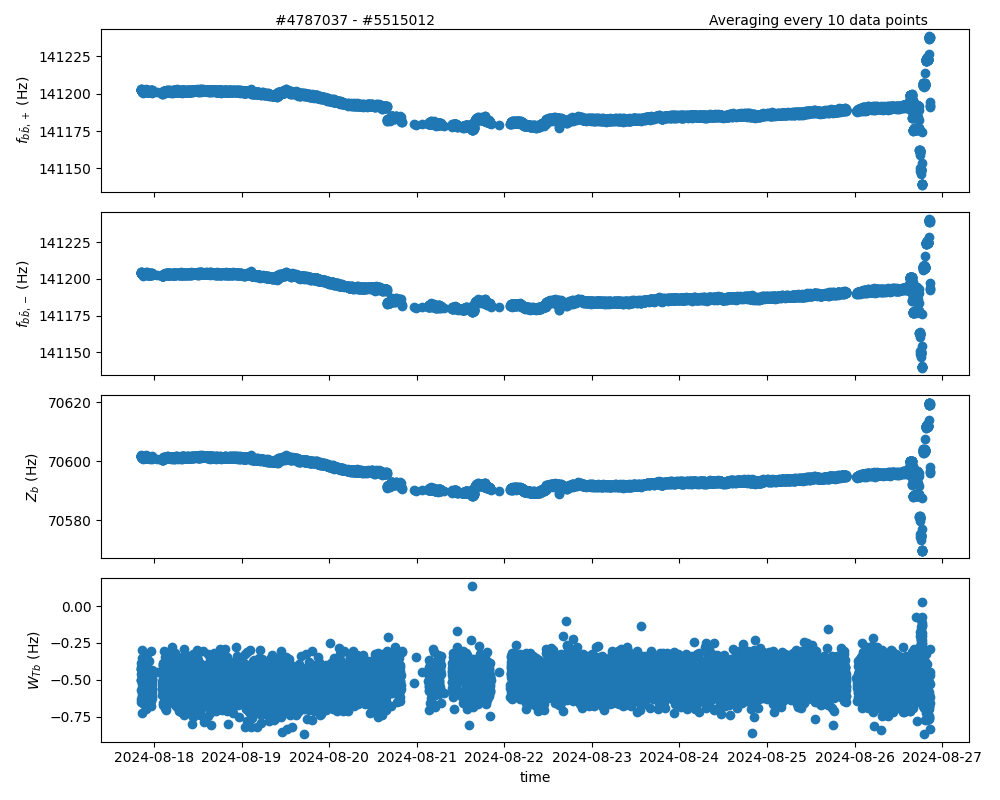

f_b,+ = 141189.34(3) Hz
f_b,- = 141190.86(3) Hz
W_T_b = -0.5027(13) Hz


In [433]:
indices_to_average = 10 # on the time series plot we will average in bins of this many data points

def down_sample(x, N):
    # pad the array x with nan until its length is a multiple of indices_to_average
    # use reshape to efficiently average every indices_to_average
    xp = np.r_[x, np.nan + np.zeros((-len(x) % N,))]
    # reshape, so each chunk gets its own row, and then take mean
    return np.nanmean(xp.reshape(-1, N), axis=-1)

errorbar_args = {"fmt": "o", "ls": "none"}
t0 = results[0, col_indices["start_time"]]

def time_to_datetime(time):
    return np.array([datetime.datetime.fromtimestamp(t + t0) for t in time])

def datetime_to_time(dt):
    return np.array([dtt.timestamp() - t0 for dtt in dt])

masks = {}
if not np.all(a_mask == False):
    masks["a"] = a_mask
if not np.all(b_mask == False):
    masks["b"] = b_mask

cols = len(masks) * 4
fig, axs = plt.subplots(cols, 1, sharex=True, figsize=(10, cols*2))
for ll, mask_name in enumerate(masks):
    mask = masks[mask_name]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    
    axs[ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, +}$ (Hz)")
    axs[len(masks) + ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, -}$ (Hz)")
    axs[len(masks) * 2 + ll].set_ylabel("$Z_" + mask_name + "$ (Hz)")
    axs[len(masks) * 3 + ll].set_ylabel("$W_{T" + mask_name + "}$ (Hz)")
    time_array = results[mask&cycle_time_mask, col_indices["start_time"]] - t0

    f_plus_averaged = down_sample(unumpy.nominal_values(results[mask&cycle_time_mask, col_indices["f+"]]), indices_to_average)
    f_minus_averaged = down_sample(unumpy.nominal_values(results[mask&cycle_time_mask, col_indices["f-"]]), indices_to_average)
    Z_averaged = down_sample(unumpy.nominal_values(results[mask&cycle_time_mask, col_indices["Z"]]), indices_to_average)
    W_T_averaged = down_sample(unumpy.nominal_values(results[mask&cycle_time_mask, col_indices["W_T"]]), indices_to_average)
    time_array_averaged = down_sample(time_array, indices_to_average)
    time_array_averaged = time_to_datetime(time_array_averaged)
    
    for kk, d in enumerate([f_plus_averaged, f_minus_averaged, Z_averaged, W_T_averaged]):
        axs[kk * len(masks) + ll].scatter(time_array_averaged, d)

    # for kk, d in enumerate(
    #     [
    #         results[mask, col_indices["f+"]],
    #         results[mask, col_indices["f-"]],
    #         results[mask, col_indices["Z"]],
    #         results[mask, col_indices["W_T"]]
    #     ]
    # ):
    #     axs[kk * len(masks) + ll].errorbar(
    #         time_array, unumpy.nominal_values(d), unumpy.std_devs(d) * 0,
    #         **errorbar_args
    #     )
        # axs[kk * len(masks) + ll].axvline(start_time, color = "red")
axs[0].text(0.2, 1.02, f'#{data_range[0]} - #{max}', transform = axs[0].transAxes)
axs[3].set_xlabel(f"time")
axs[0].text(0.7, 1.02, f"Averaging every {indices_to_average} data points", transform = axs[0].transAxes)
#ax1 = axs[0].secondary_xaxis("top", functions=(time_to_datetime, datetime_to_time))
plt.tight_layout()
plt.show()
mask = masks["b"]
E_pos = E_pos_mask[mask]
E_neg = E_neg_mask[mask]
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
#print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
print("W_T_b =", present_float(np.average(unumpy.nominal_values(W_T_b)), np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))), "Hz")

In [434]:
# full experiment
mask = start_mask & cycle_time_mask
duration = np.max(results[:, col_indices["start_time"]][mask]) - np.min(results[:, col_indices["start_time"]][mask])
E_pos = E_pos_mask[mask]
E_neg = E_neg_mask[mask]

W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b[mask]))) / np.sqrt(len(W_T_b[mask]))
Ncycle = len(results)

print(f'#{data_range[0]} - #{max}')
print(f"Time: {duration:.1f} s")
print(f"Cycle time: {duration / Ncycle:.1f} s")
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
print(f"N_cycle = {Ncycle}")
print(f"W_T_unc per cycle = {W_tb_unc*np.sqrt(Ncycle):.2f} Hz")
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")
print("W_T / uncertainty =", round(np.average(unumpy.nominal_values(W_T_b))/ W_tb_unc, 2))
# get_cycle_snr(5)

#4787037 - #5515012
Time: 778825.2 s
Cycle time: 8.6 s
0.015 Hz sqrt(hr)
N_cycle = 90994
W_T_unc per cycle = 0.31 Hz
f_b,+ = 141189.34(3) Hz
f_b,- = 141190.86(3) Hz
W_T = -0.5027(10) Hz
W_T / uncertainty = -488.13


In [385]:
# full experiment with cycle time mask
duration = np.max(results[:, col_indices["start_time"]][start_mask]) - np.min(results[:, col_indices["start_time"]][start_mask])
E_pos = E_pos_mask[mask][start_mask]
E_neg = E_neg_mask[mask][start_mask]

W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b[start_mask]))) / np.sqrt(len(W_T_b[start_mask]))
Ncycle = len(results)

print(f'#{data_range[0]} - #{max}')
print(f"Time: {duration:.1f} s")
print(f"Cycle time: {duration / Ncycle:.1f} s")
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
print(f"N_cycle = {Ncycle}")
print(f"W_T_unc per cycle = {W_tb_unc*np.sqrt(Ncycle):.2f} Hz")
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")
print("W_T / uncertainty =", round(np.average(unumpy.nominal_values(W_T_b))/ W_tb_unc, 2))
# get_cycle_snr(5)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 84317 but corresponding boolean dimension is 90049

In [ ]:
## first 10,000 experiments
duration = np.max(results[:, col_indices["start_time"]][start_mask][0:10000]) - np.min(results[:, col_indices["start_time"]][start_mask][0:10000])
E_pos = E_pos_mask[mask][start_mask][0:10000]
E_neg = E_neg_mask[mask][start_mask][0:10000]

W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b[start_mask][0:10000]))) / np.sqrt(len(W_T_b[start_mask][0:10000]))
Ncycle = 10000 #len(results)

print(f'#{data_range[0]} - #{max}')
print(f"Time: {duration:.1f} s")
print(f"Cycle time: {duration / Ncycle:.1f} s")
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
print(f"N_cycle = {Ncycle}")
print(f"W_T_unc per cycle = {W_tb_unc*np.sqrt(Ncycle):.2f} Hz")
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b[0:10000])), np.average(np.std(unumpy.nominal_values(f_p_b[0:10000]))) / np.sqrt(len(f_p_b[0:10000]))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b[0:10000])), np.average(np.std(unumpy.nominal_values(f_m_b[0:10000]))) / np.sqrt(len(f_m_b[0:10000]))), "Hz")
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b[0:10000])), W_tb_unc, 2), "Hz")
print("W_T / uncertainty =", round(np.average(unumpy.nominal_values(W_T_b[0:10000]))/ W_tb_unc, 2))
# get_cycle_snr(5)

In [ ]:
## remaining experiments
duration = np.max(results[:, col_indices["start_time"]][start_mask][10000:]) - np.min(results[:, col_indices["start_time"]][start_mask][10000:])
E_pos = E_pos_mask[mask][start_mask][10000:]
E_neg = E_neg_mask[mask][start_mask][10000:]

W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b[start_mask][10000:]))) / np.sqrt(len(W_T_b[start_mask][10000:]))
Ncycle = len(results) - 10000

print(f'#{data_range[0]} - #{max}')
print(f"Time: {duration:.1f} s")
print(f"Cycle time: {duration / Ncycle:.1f} s")
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
print(f"N_cycle = {Ncycle}")
print(f"W_T_unc per cycle = {W_tb_unc*np.sqrt(Ncycle):.2f} Hz")
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b[10000:])), np.average(np.std(unumpy.nominal_values(f_p_b[10000:]))) / np.sqrt(len(f_p_b[10000:]))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b[10000:])), np.average(np.std(unumpy.nominal_values(f_m_b[10000:]))) / np.sqrt(len(f_m_b[10000:]))), "Hz")
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b[10000:])), W_tb_unc, 2), "Hz")
print("W_T / uncertainty =", round(np.average(unumpy.nominal_values(W_T_b[10000:]))/ W_tb_unc, 2))
# get_cycle_snr(5)

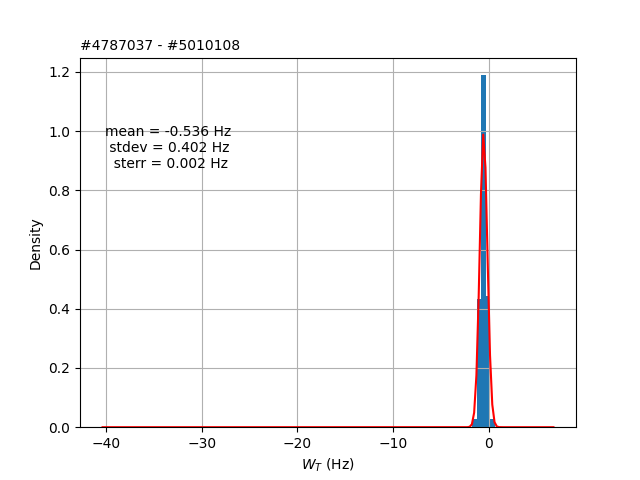

average =  -0.5356300630195653
stdev =  0.4019426618933255
sterr =  0.002407187564166744


In [8]:
to_hist = unumpy.nominal_values(W_T_b[start_mask])
to_hist_avg = np.average(to_hist)
to_hist_std = np.std(to_hist)
gaussian_x = np.linspace(np.min(to_hist), np.max(to_hist), 200)
gaussian_y = 1/(to_hist_std*np.sqrt(2*np.pi)) * np.exp(-0.5*((gaussian_x-to_hist_avg)/to_hist_std)**2)
fig, ax = plt.subplots()

ax.hist(to_hist, bins = 100, density = True)
ax.plot(gaussian_x, gaussian_y, color='red')

ax.grid()
ax.set_xlabel("$W_T$ (Hz)")
ax.set_ylabel("Density")
ax.text(0, 1.02, f'#{data_range[0]} - #{max}', transform = ax.transAxes)
ax.text(0.05,0.7, f"mean = {round(to_hist_avg, 3)} Hz \n stdev = {round(to_hist_std, 3)} Hz \n  sterr = {round(to_hist_std/np.sqrt(Ncycle), 3)} Hz", transform = ax.transAxes)

plt.show()
print("average = ", to_hist_avg)
print("stdev = ", to_hist_std)
print("sterr = ", to_hist_std/np.sqrt(Ncycle))

/tmp/ipykernel_3185560/2112979061.py:12: RuntimeWarning: divide by zero encountered in log
  log_density = np.log(hist)


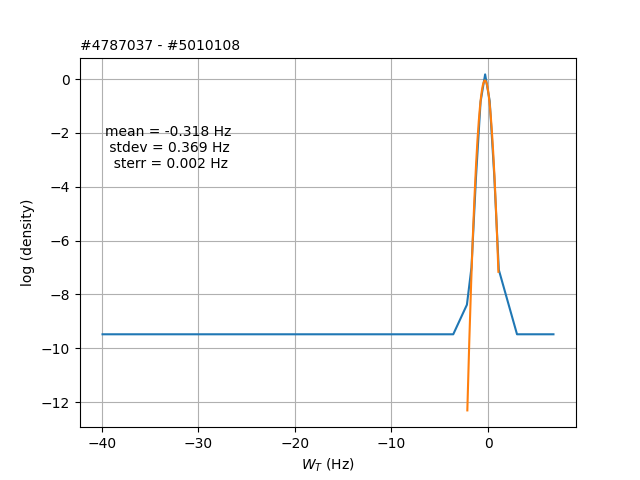

average =  -0.31790018244516166
stdev =  0.3686690066765654
sterr =  0.0022079155369704516


In [35]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c
    
to_hist = unumpy.nominal_values(W_T_b[start_mask])
to_hist_avg = np.average(to_hist)
to_hist_std = np.std(to_hist)

fig, ax = plt.subplots()

hist, bin_edges = np.histogram(to_hist, bins = 100, density = True)
bin_centers = bin_edges[:-1] + np.average(np.diff(bin_edges))  
log_density = np.log(hist)
bad_indices = np.argwhere(log_density == -np.inf)
log_density_clean = np.delete(log_density, bad_indices)
bin_centers_clean = np.delete(bin_centers, bad_indices)

bins_positive_edge = to_hist_avg + 3 * to_hist_std
bins_negative_edge = to_hist_avg - 3 * to_hist_std
bins_too_low = np.argwhere( bin_centers_clean < bins_negative_edge)
bins_too_large = np.argwhere( bin_centers_clean > bins_positive_edge)
bins_to_ignore = np.concatenate((bins_too_low, bins_too_large), axis = 0)

bins_to_fit = np.delete(bin_centers_clean, bins_to_ignore)
log_density_to_fit = np.delete(log_density_clean, bins_to_ignore)

ax.plot(bin_centers_clean, log_density_clean)

fitter = Fitter(parabola)
fitter.set_data(bins_to_fit, log_density_to_fit)
fitter.set_p0({"a": -0.5 / to_hist_std**2,
               "b": 0.5 * to_hist_avg /to_hist_std**2,
               "c": -0.5* to_hist_avg**2 / to_hist_avg**2
              })
fitter.fit()
sigma = np.sqrt(-0.5 / fitter.results["a"])
mean = sigma**2 * fitter.results["b"]

xaxis = np.linspace(to_hist_avg-4*to_hist_std,to_hist_avg+4*to_hist_std,400)
ax.plot(xaxis, fitter.fitted_value(xaxis))

ax.grid()
ax.set_xlabel("$W_T$ (Hz)")
ax.set_ylabel("log (density)")
ax.text(0, 1.02, f'#{data_range[0]} - #{max}', transform = ax.transAxes)
ax.text(0.05,0.7, f"mean = {round(mean, 3)} Hz \n stdev = {round(sigma, 3)} Hz \n  sterr = {round(sigma/np.sqrt(Ncycle), 3)} Hz", transform = ax.transAxes)

plt.show()
print("average = ", mean)
print("stdev = ", sigma)
print("sterr = ", sigma/np.sqrt(Ncycle))

/tmp/ipykernel_3185560/1354815446.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  step_sizes = [total_time / len(kk[1]) for kk in allan_variables]


Cannot plot  $f_b (D=+1, E=-1)$
Cannot plot  $f_b (D=-1, E=-1)$
Cannot plot  $\Delta f_b (D=\pm1, E=-1)$


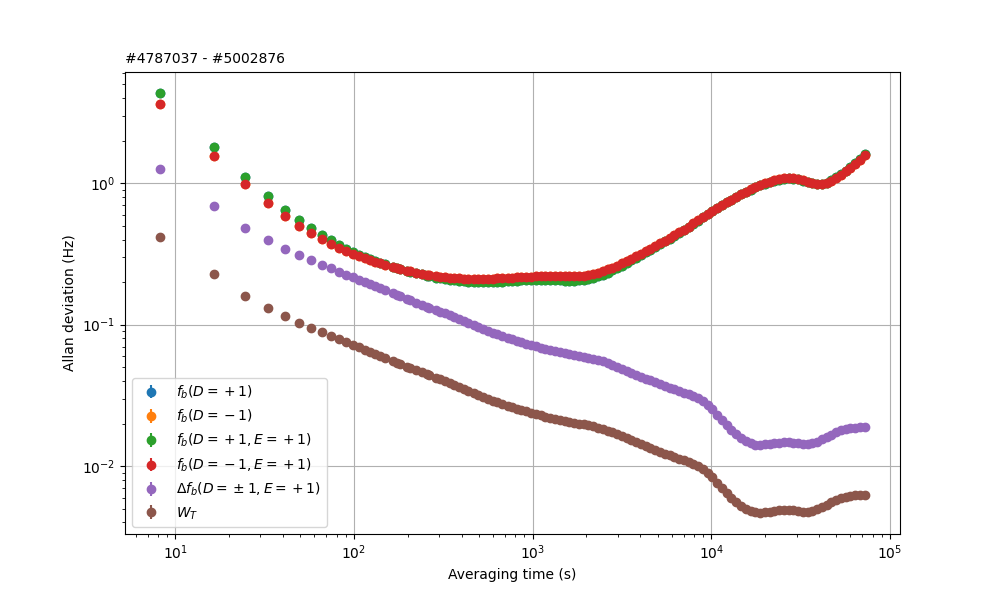

In [23]:
times = results[:, col_indices["start_time"]].astype(float)
taus = np.logspace(0, np.log10(len(times)) * 3, 500)
total_time = times[-1] - times[0]

allan_variables = [
    ("$f_b (D=+1)$", unumpy.nominal_values(results[:, col_indices["f+"]])),
    ("$f_b (D=-1)$", unumpy.nominal_values(results[:, col_indices["f-"]])),
    ("$f_b (D=+1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f+"]])),
    ("$f_b (D=-1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f-"]])),
    ("$f_b (D=+1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f+"]])),
    ("$f_b (D=-1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f-"]])),
    (
        "$\\Delta f_b (D=\\pm1, E=+1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == True, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == True, col_indices["f-"]]
        )
    ),
    (
        "$\\Delta f_b (D=\\pm1, E=-1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == False, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == False, col_indices["f-"]]
        )
    ),
    ("$W_T$", unumpy.nominal_values(results[:, col_indices["W_T"]])),
]
step_sizes = [total_time / len(kk[1]) for kk in allan_variables]

fig, ax = plt.subplots(figsize=(10, 6))
for kk, (label, variable) in enumerate(allan_variables):
    try:
        real_taus, allan, allan_err, _ = mdev(variable, data_type="freq", taus=taus)
        real_taus *= step_sizes[kk]
        ax.errorbar(real_taus, allan, allan_err, label=label, ls="none", fmt="o")
    except:
        print("Cannot plot ", label)
        continue
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()
ax.set_xlabel("Averaging time (s)")
ax.set_ylabel("Allan deviation (Hz)")
ax.text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax.transAxes)
plt.show()

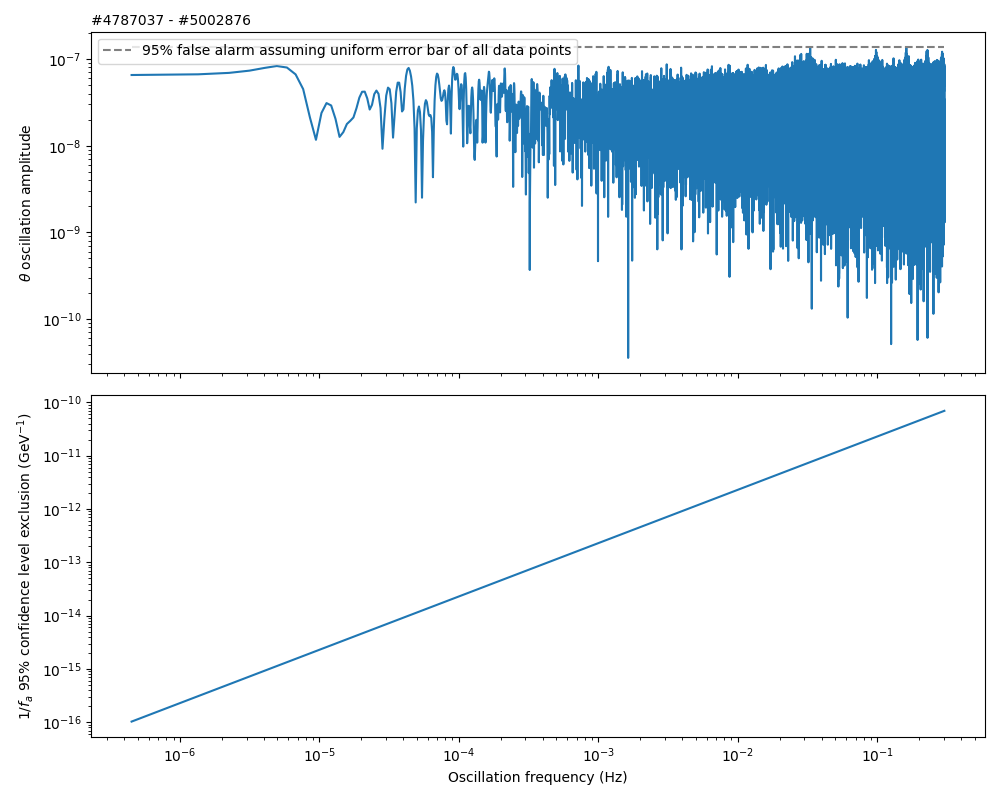

In [24]:
W_T_to_theta = 2.5e-5
# https://electricatoms.wordpress.com/2024/07/11/t-violation-measurement-from-lf-spectroscopy/
thetas = unumpy.nominal_values(results[:, col_indices["W_T"]])[start_mask] * W_T_to_theta
times = results[:, col_indices["start_time"]].astype(float)[start_mask]

theta_uncs = np.std(thetas) * np.ones(len(thetas))  # assuming error bar is std of the data for every point
ls = LombScargle(times, thetas, theta_uncs, normalization="psd")
fs, f_thetas_psd = ls.autopower()
f_thetas_amplitude_normalized = np.sqrt(f_thetas_psd / (len(f_thetas_psd) / 4))
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
f_thetas_amplitude = f_thetas_amplitude_normalized * np.std(thetas)
# https://docs.astropy.org/en/stable/timeseries/lombscargle.html#psd-normalization-unnormalized

confidence = 0.95
f_thetas_limit_psd = ls.false_alarm_level(1 - confidence)
f_thetas_limit_amplitude = np.sqrt(f_thetas_limit_psd / (len(f_thetas_psd) / 4)) * np.std(thetas)
# same normalization as above

inverse_fa_limits = inverse_fa_limit(fs, f_thetas_limit_amplitude * np.ones(len(fs)))

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(fs, f_thetas_amplitude)
ax[0].hlines([f_thetas_limit_amplitude], np.min(fs), np.max(fs), color="gray", ls="--", label=f"{confidence*100:.0f}% false alarm assuming uniform error bar of all data points")
ax[0].set_ylabel("$\\theta$ oscillation amplitude")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax[0].transAxes)
ax[0].legend()

ax[1].plot(fs, inverse_fa_limits)
ax[1].set_xlabel("Oscillation frequency (Hz)")
ax[1].set_ylabel(f"$1 / f_a$ {confidence*100:.0f}% confidence level" + " exclusion (GeV$^{-1}$)")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
plt.tight_layout()
plt.show()


In [25]:
times = (results[:, col_indices["start_time"]][start_mask][1:] - results[:, col_indices["start_time"]][start_mask][:-1])

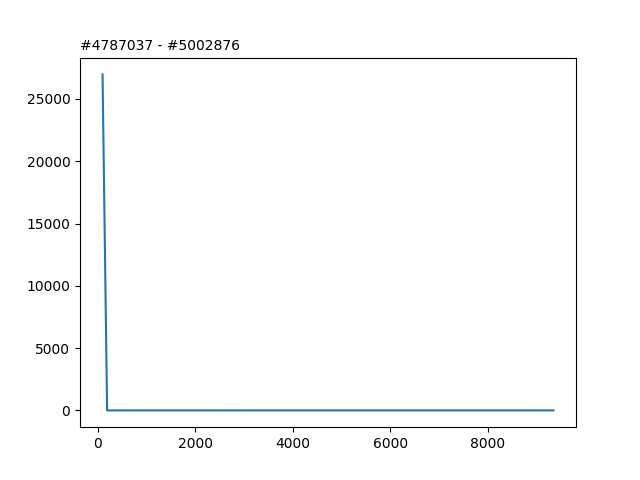

In [26]:
hist, x = np.histogram(times, bins=100)
fig, ax = plt.subplots()
ax.plot(x[1:], hist)
ax.text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax.transAxes)
plt.show()

In [89]:

######### chasm, no mirror
# data_range = (4657576, 4657583)
# max = 4659175

######### no chasm, mirror
# data_range = (4659176, 4659183)
# max = 4660775

# data_range = (4787037, 4787044)
# max = 4942756

data_range =  (4738954, 4738961)
max = 4772529

results, col_indices = analyze_data(data_range, max, get_results, save_new=True)

Existing data loaded


In [218]:
# last 4726136

In [90]:
np.max(results[:,col_indices["end_time"]])

1723879906.225536

In [94]:
start_time = 0
start_mask = results[:, col_indices["start_time"]] > start_time

a_mask = results[:, col_indices["state"]] == "a"
b_mask = results[:, col_indices["state"]] == "b"

E_fields = np.unique(results[:, col_indices["field_plate_amplitude"]])
E_masks = [results[:, col_indices["field_plate_amplitude"]] == kk for kk in E_fields]

rf_amplitudes = np.unique(results[:, col_indices["rf_amplitude"]])
rf_amplitude_masks = [results[:, col_indices["rf_amplitude"]] == kk for kk in rf_amplitudes]

rf_durations = np.unique(results[:, col_indices["rf_duration_ms"]])
rf_duration_masks = [results[:, col_indices["rf_duration_ms"]] == kk for kk in rf_durations]

durations = np.unique(results[:, col_indices["pulse_time_ms"]])
duration_masks = [results[:, col_indices["pulse_time_ms"]] == kk for kk in durations]

E_pos_mask = results[:, col_indices["E"]] == True
E_neg_mask = results[:, col_indices["E"]] == False

start_times_a = results[a_mask, col_indices["start_time"]]
start_times_b = results[b_mask, col_indices["start_time"]]
f_p_a = results[a_mask, col_indices["f+"]]
f_m_a = results[a_mask, col_indices["f-"]]
f_p_b = results[b_mask, col_indices["f+"]]
f_m_b = results[b_mask, col_indices["f-"]]

Z_a = results[a_mask, col_indices["Z"]]
Z_b = results[b_mask, col_indices["Z"]]
W_T_a = results[a_mask, col_indices["W_T"]]
W_T_b = results[b_mask, col_indices["W_T"]]

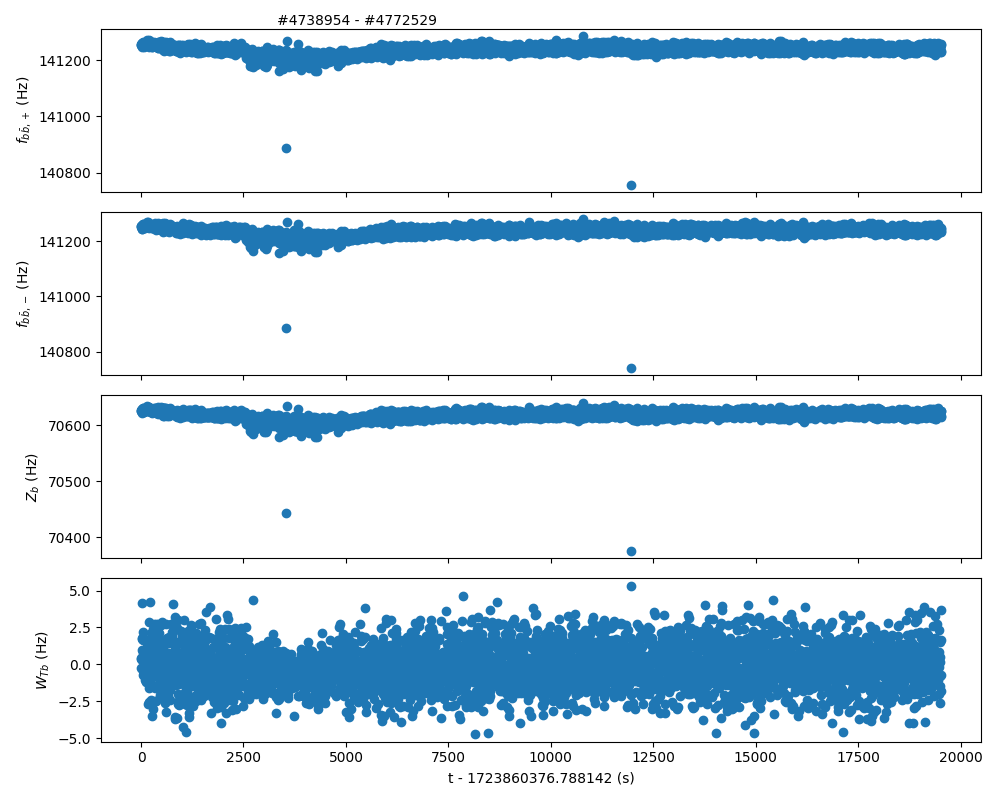

f_b,+ = 141235.9(3) Hz
f_b,- = 141236.2(3) Hz
W_T_b = -0.09(2) Hz


In [95]:
errorbar_args = {"fmt": "o", "ls": "none"}

masks = {}
if not np.all(a_mask == False):
    masks["a"] = a_mask
if not np.all(b_mask == False):
    masks["b"] = b_mask

cols = len(masks) * 4
fig, axs = plt.subplots(cols, 1, sharex=True, figsize=(10, cols*2))
for ll, mask_name in enumerate(masks):
    mask = masks[mask_name]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    
    axs[ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, +}$ (Hz)")
    axs[len(masks) + ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, -}$ (Hz)")
    axs[len(masks) * 2 + ll].set_ylabel("$Z_" + mask_name + "$ (Hz)")
    axs[len(masks) * 3 + ll].set_ylabel("$W_{T" + mask_name + "}$ (Hz)")
    t0 = results[mask, col_indices["start_time"]][0]
    time_array = results[mask, col_indices["start_time"]] - t0
    for kk, d in enumerate(
        [
            results[mask, col_indices["f+"]],
            results[mask, col_indices["f-"]],
            results[mask, col_indices["Z"]],
            results[mask, col_indices["W_T"]]
        ]
    ):
        axs[kk * len(masks) + ll].errorbar(
            time_array, unumpy.nominal_values(d), unumpy.std_devs(d) * 0,
            **errorbar_args
        )
        # axs[kk * len(masks) + ll].axvline(start_time, color = "red")
axs[0].text(0.2, 1.02, f'#{data_range[0]} - #{max}', transform = axs[0].transAxes)
axs[3].set_xlabel(f"t - {t0} (s)")
plt.tight_layout()
plt.show()
mask = masks["b"]
E_pos = E_pos_mask[mask]
E_neg = E_neg_mask[mask]
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
#print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
print("W_T_b =", present_float(np.average(unumpy.nominal_values(W_T_b)), np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))), "Hz")

In [96]:
duration = np.max(results[:, col_indices["start_time"]][start_mask]) - np.min(results[:, col_indices["start_time"]][start_mask])
E_pos = E_pos_mask[mask][start_mask]
E_neg = E_neg_mask[mask][start_mask]

W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b[start_mask]))) / np.sqrt(len(W_T_b[start_mask]))
Ncycle = len(results)

print(f'#{data_range[0]} - #{max}')
print(f"Time: {duration:.1f} s")
print(f"Cycle time: {duration / Ncycle:.1f} s")
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
print(f"N_cycle = {Ncycle}")
print(f"W_T_unc per cycle = {W_tb_unc*np.sqrt(Ncycle):.2f} Hz")
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")
print("W_T / uncertainty =", round(np.average(unumpy.nominal_values(W_T_b))/ W_tb_unc, 2))
# get_cycle_snr(5)

#4738954 - #4772529
Time: 19525.4 s
Cycle time: 4.7 s
0.051 Hz sqrt(hr)
N_cycle = 4197
W_T_unc per cycle = 1.41 Hz
f_b,+ = 141235.9(3) Hz
f_b,- = 141236.2(3) Hz
W_T = -0.091(22) Hz
W_T / uncertainty = -4.19


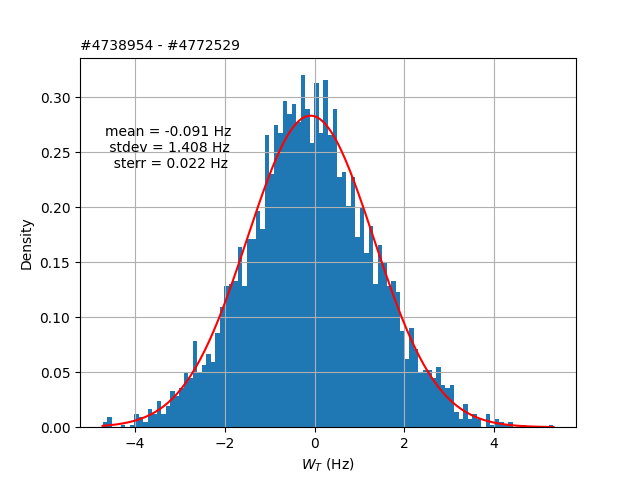

average =  -0.09107829724214113
stdev =  1.4077816922194262
sterr =  0.02173030532216183
100


In [97]:
to_hist = unumpy.nominal_values(W_T_b[start_mask])
to_hist_avg = np.average(to_hist)
to_hist_std = np.std(to_hist)
gaussian_x = np.linspace(np.min(to_hist), np.max(to_hist), 200)
gaussian_y = 1/(to_hist_std*np.sqrt(2*np.pi)) * np.exp(-0.5*((gaussian_x-to_hist_avg)/to_hist_std)**2)
fig, ax = plt.subplots()

ax.hist(to_hist, bins = 100, density = True)
ax.plot(gaussian_x, gaussian_y, color='red')

ax.grid()
ax.set_xlabel("$W_T$ (Hz)")
ax.set_ylabel("Density")
ax.text(0, 1.02, f'#{data_range[0]} - #{max}', transform = ax.transAxes)
ax.text(0.05,0.7, f"mean = {round(to_hist_avg, 3)} Hz \n stdev = {round(to_hist_std, 3)} Hz \n  sterr = {round(to_hist_std/np.sqrt(Ncycle), 3)} Hz", transform = ax.transAxes)

plt.show()
print("average = ", to_hist_avg)
print("stdev = ", to_hist_std)
print("sterr = ", to_hist_std/np.sqrt(Ncycle))
print(len(bin_centers))

In [98]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

/tmp/ipykernel_3171795/3437405323.py:9: RuntimeWarning: divide by zero encountered in log
  log_density = np.log(hist)


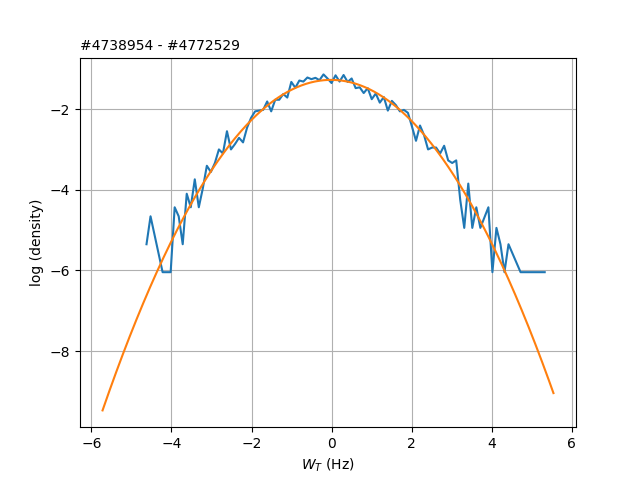

average =  -0.09107829724214113
stdev =  1.4077816922194262
sterr =  0.02173030532216183
100


In [99]:
to_hist = unumpy.nominal_values(W_T_b[start_mask])
to_hist_avg = np.average(to_hist)
to_hist_std = np.std(to_hist)

fig, ax = plt.subplots()

hist, bin_edges = np.histogram(to_hist, bins = 100, density = True)
bin_centers = bin_edges[:-1] + np.average(np.diff(bin_edges))  
log_density = np.log(hist)
bad_indices = np.argwhere(log_density == -np.inf)
log_density_clean = np.delete(log_density, bad_indices)
bin_centers_clean = np.delete(bin_centers, bad_indices)

bins_positive_edge = to_hist_avg + 3 * to_hist_std
bins_negative_edge = to_hist_avg - 3 * to_hist_std
bins_too_low = np.argwhere( bin_centers_clean < bins_negative_edge)
bins_too_large = np.argwhere( bin_centers_clean > bins_positive_edge)
bins_to_ignore = np.concatenate((bins_too_low, bins_too_large), axis = 0)

bins_to_fit = np.delete(bin_centers_clean, bins_to_ignore)
log_density_to_fit = np.delete(log_density_clean, bins_to_ignore)

ax.plot(bin_centers_clean, log_density_clean)

fitter = Fitter(parabola)
fitter.set_data(bins_to_fit, log_density_to_fit)
fitter.set_p0({"a": -0.5 / to_hist_std**2,
               "b": 0.5 * to_hist_avg /to_hist_std**2,
               "c": -0.5* to_hist_avg**2 / to_hist_avg**2
              })
fitter.fit()
#sigma = np.sqrt(-0.5 / fitter.results["a"])
# m

xaxis = np.linspace(to_hist_avg-4*to_hist_std,to_hist_avg+4*to_hist_std,400)
ax.plot(xaxis, fitter.fitted_value(xaxis))

ax.grid()
ax.set_xlabel("$W_T$ (Hz)")
ax.set_ylabel("log (density)")
ax.text(0, 1.02, f'#{data_range[0]} - #{max}', transform = ax.transAxes)
#ax.text(0.05,0.7, f"mean = {round(to_hist_avg, 3)} Hz \n stdev = {round(to_hist_std, 3)} Hz \n  sterr = {round(to_hist_std/np.sqrt(Ncycle), 3)} Hz", transform = ax.transAxes)

plt.show()
print("average = ", to_hist_avg)
print("stdev = ", to_hist_std)
print("sterr = ", to_hist_std/np.sqrt(Ncycle))
print(len(bin_centers))

Cannot plot  $f_b (D=+1, E=-1)$
Cannot plot  $f_b (D=-1, E=-1)$
Cannot plot  $\Delta f_b (D=\pm1, E=-1)$


/tmp/ipykernel_3171795/1354815446.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  step_sizes = [total_time / len(kk[1]) for kk in allan_variables]


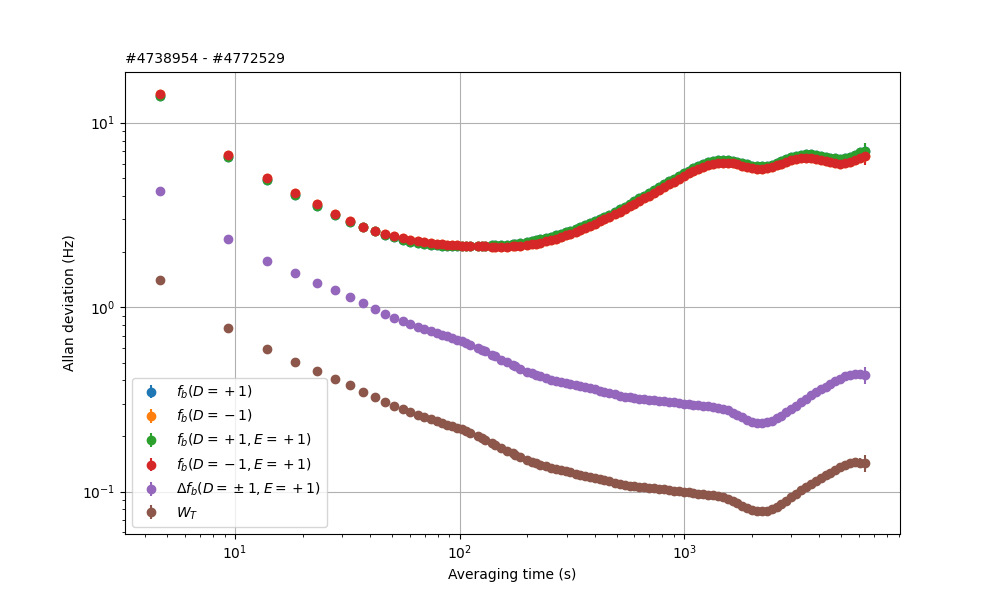

In [100]:
times = results[:, col_indices["start_time"]].astype(float)
taus = np.logspace(0, np.log10(len(times)) * 3, 500)
total_time = times[-1] - times[0]

allan_variables = [
    ("$f_b (D=+1)$", unumpy.nominal_values(results[:, col_indices["f+"]])),
    ("$f_b (D=-1)$", unumpy.nominal_values(results[:, col_indices["f-"]])),
    ("$f_b (D=+1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f+"]])),
    ("$f_b (D=-1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f-"]])),
    ("$f_b (D=+1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f+"]])),
    ("$f_b (D=-1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f-"]])),
    (
        "$\\Delta f_b (D=\\pm1, E=+1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == True, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == True, col_indices["f-"]]
        )
    ),
    (
        "$\\Delta f_b (D=\\pm1, E=-1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == False, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == False, col_indices["f-"]]
        )
    ),
    ("$W_T$", unumpy.nominal_values(results[:, col_indices["W_T"]])),
]
step_sizes = [total_time / len(kk[1]) for kk in allan_variables]

fig, ax = plt.subplots(figsize=(10, 6))
for kk, (label, variable) in enumerate(allan_variables):
    try:
        real_taus, allan, allan_err, _ = mdev(variable, data_type="freq", taus=taus)
        real_taus *= step_sizes[kk]
        ax.errorbar(real_taus, allan, allan_err, label=label, ls="none", fmt="o")
    except:
        print("Cannot plot ", label)
        continue
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()
ax.set_xlabel("Averaging time (s)")
ax.set_ylabel("Allan deviation (Hz)")
ax.text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax.transAxes)
plt.show()

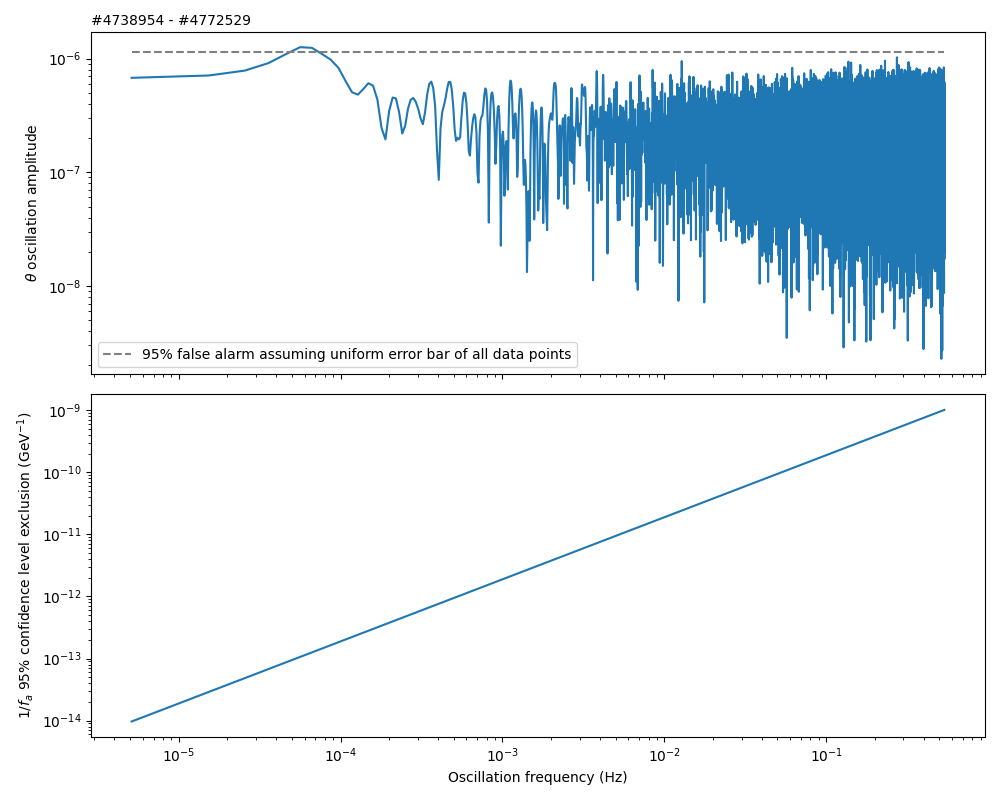

In [101]:
W_T_to_theta = 2.5e-5
# https://electricatoms.wordpress.com/2024/07/11/t-violation-measurement-from-lf-spectroscopy/
thetas = unumpy.nominal_values(results[:, col_indices["W_T"]])[start_mask] * W_T_to_theta
times = results[:, col_indices["start_time"]].astype(float)[start_mask]

theta_uncs = np.std(thetas) * np.ones(len(thetas))  # assuming error bar is std of the data for every point
ls = LombScargle(times, thetas, theta_uncs, normalization="psd")
fs, f_thetas_psd = ls.autopower()
f_thetas_amplitude_normalized = np.sqrt(f_thetas_psd / (len(f_thetas_psd) / 4))
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
f_thetas_amplitude = f_thetas_amplitude_normalized * np.std(thetas)
# https://docs.astropy.org/en/stable/timeseries/lombscargle.html#psd-normalization-unnormalized

confidence = 0.95
f_thetas_limit_psd = ls.false_alarm_level(1 - confidence)
f_thetas_limit_amplitude = np.sqrt(f_thetas_limit_psd / (len(f_thetas_psd) / 4)) * np.std(thetas)
# same normalization as above

inverse_fa_limits = inverse_fa_limit(fs, f_thetas_limit_amplitude * np.ones(len(fs)))

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(fs, f_thetas_amplitude)
ax[0].hlines([f_thetas_limit_amplitude], np.min(fs), np.max(fs), color="gray", ls="--", label=f"{confidence*100:.0f}% false alarm assuming uniform error bar of all data points")
ax[0].set_ylabel("$\\theta$ oscillation amplitude")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax[0].transAxes)
ax[0].legend()

ax[1].plot(fs, inverse_fa_limits)
ax[1].set_xlabel("Oscillation frequency (Hz)")
ax[1].set_ylabel(f"$1 / f_a$ {confidence*100:.0f}% confidence level" + " exclusion (GeV$^{-1}$)")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
plt.tight_layout()
plt.show()


In [102]:
times = (results[:, col_indices["start_time"]][start_mask][1:] - results[:, col_indices["start_time"]][start_mask][:-1])

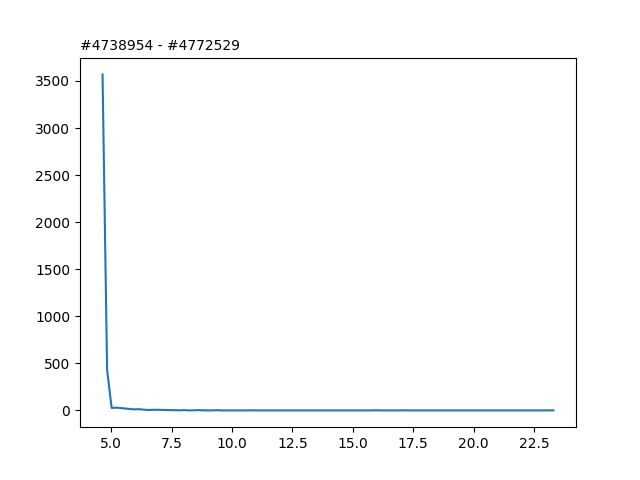

In [103]:
hist, x = np.histogram(times, bins=100)
fig, ax = plt.subplots()
ax.plot(x[1:], hist)
ax.text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax.transAxes)
plt.show()

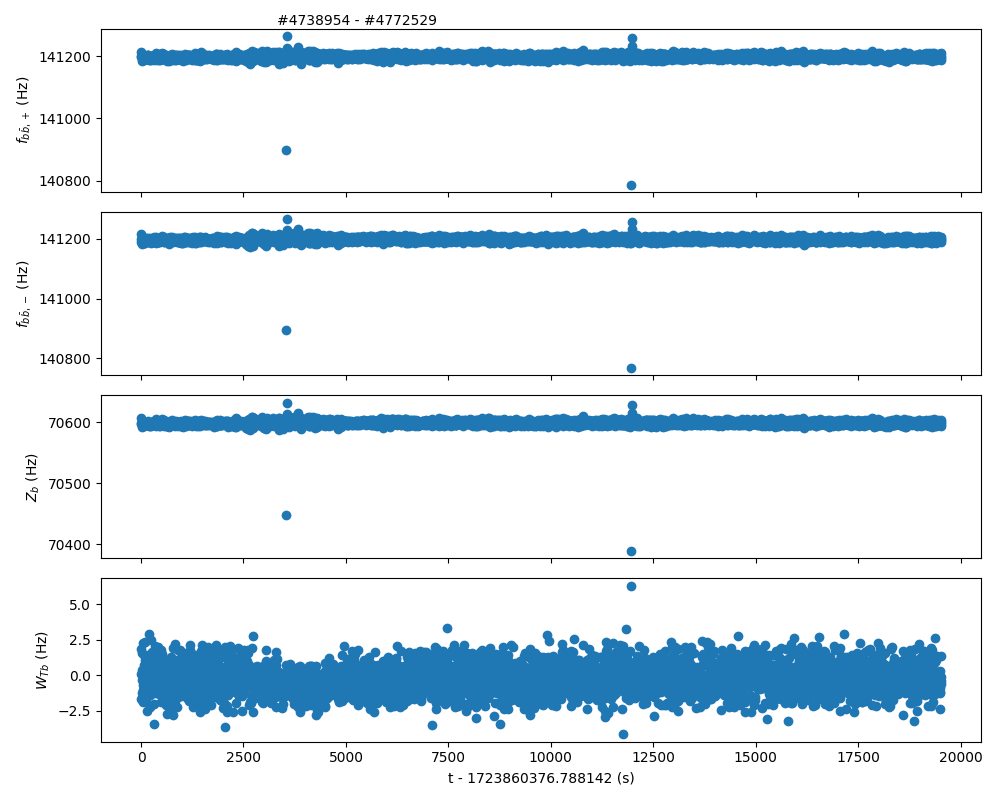

f_b,+ = 141197.90(15) Hz
f_b,- = 141198.50(16) Hz
W_T_b = -0.199(15) Hz


In [154]:
errorbar_args = {"fmt": "o", "ls": "none"}

masks = {}
if not np.all(a_mask == False):
    masks["a"] = a_mask
if not np.all(b_mask == False):
    masks["b"] = b_mask

cols = len(masks) * 4
fig, axs = plt.subplots(cols, 1, sharex=True, figsize=(10, cols*2))
for ll, mask_name in enumerate(masks):
    mask = masks[mask_name]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    
    axs[ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, +}$ (Hz)")
    axs[len(masks) + ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, -}$ (Hz)")
    axs[len(masks) * 2 + ll].set_ylabel("$Z_" + mask_name + "$ (Hz)")
    axs[len(masks) * 3 + ll].set_ylabel("$W_{T" + mask_name + "}$ (Hz)")
    t0 = results[mask, col_indices["start_time"]][0]
    time_array = results[mask, col_indices["start_time"]] - t0
    for kk, d in enumerate(
        [
            results[mask, col_indices["f+"]],
            results[mask, col_indices["f-"]],
            results[mask, col_indices["Z"]],
            results[mask, col_indices["W_T"]]
        ]
    ):
        axs[kk * len(masks) + ll].errorbar(
            time_array, unumpy.nominal_values(d), unumpy.std_devs(d) * 0,
            **errorbar_args
        )
        # axs[kk * len(masks) + ll].axvline(start_time, color = "red")
axs[0].text(0.2, 1.02, f'#{data_range[0]} - #{max}', transform = axs[0].transAxes)
axs[3].set_xlabel(f"t - {t0} (s)")
plt.tight_layout()
plt.show()
mask = masks["b"]
E_pos = E_pos_mask[mask]
E_neg = E_neg_mask[mask]
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
#print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
print("W_T_b =", present_float(np.average(unumpy.nominal_values(W_T_b)), np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))), "Hz")

In [167]:
duration = np.max(results[:, col_indices["start_time"]][start_mask]) - np.min(results[:, col_indices["start_time"]][start_mask])
E_pos = E_pos_mask[mask][start_mask]
E_neg = E_neg_mask[mask][start_mask]

W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b[start_mask]))) / np.sqrt(len(W_T_b[start_mask]))
Ncycle = len(results)

print(f'#{data_range[0]} - #{max}')
print(f"Time: {duration:.1f} s")
print(f"Cycle time: {duration / Ncycle:.1f} s")
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
print(f"N_cycle = {Ncycle}")
print(f"W_T_unc per cycle = {W_tb_unc*np.sqrt(Ncycle):.2f} Hz")
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")
print("W_T / uncertainty =", round(np.average(unumpy.nominal_values(W_T_b))/ W_tb_unc, 2))
# get_cycle_snr(5)

#4738954 - #4772529
Time: 19525.4 s
Cycle time: 4.7 s
0.029 Hz sqrt(hr)
N_cycle = 4197
W_T_unc per cycle = 0.80 Hz
f_b,+ = 141198.32(16) Hz
f_b,- = 141198.93(16) Hz
W_T = -0.205(12) Hz
W_T / uncertainty = -16.53


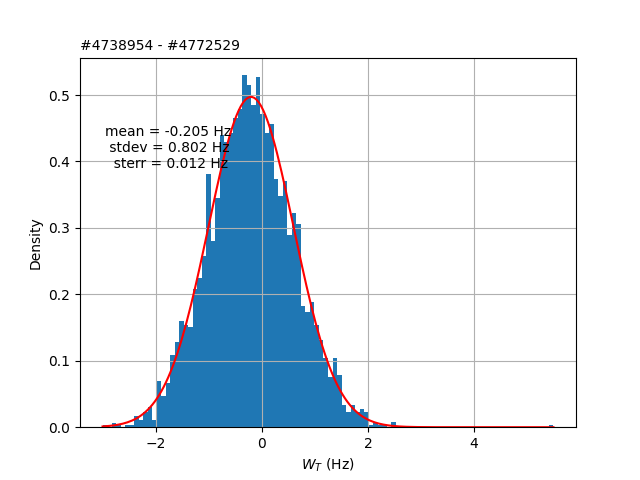

average =  -0.20466292031151762
stdev =  0.8023194277062268
sterr =  0.01238448136264083
100


In [121]:
to_hist = unumpy.nominal_values(W_T_b[start_mask])
to_hist_avg = np.average(to_hist)
to_hist_std = np.std(to_hist)
gaussian_x = np.linspace(np.min(to_hist), np.max(to_hist), 200)
gaussian_y = 1/(to_hist_std*np.sqrt(2*np.pi)) * np.exp(-0.5*((gaussian_x-to_hist_avg)/to_hist_std)**2)
fig, ax = plt.subplots()

ax.hist(to_hist, bins = 100, density = True)
ax.plot(gaussian_x, gaussian_y, color='red')

ax.grid()
ax.set_xlabel("$W_T$ (Hz)")
ax.set_ylabel("Density")
ax.text(0, 1.02, f'#{data_range[0]} - #{max}', transform = ax.transAxes)
ax.text(0.05,0.7, f"mean = {round(to_hist_avg, 3)} Hz \n stdev = {round(to_hist_std, 3)} Hz \n  sterr = {round(to_hist_std/np.sqrt(Ncycle), 3)} Hz", transform = ax.transAxes)

plt.show()
print("average = ", to_hist_avg)
print("stdev = ", to_hist_std)
print("sterr = ", to_hist_std/np.sqrt(Ncycle))
print(len(bin_centers))

In [122]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

/tmp/ipykernel_3171795/1896227032.py:9: RuntimeWarning: divide by zero encountered in log
  log_density = np.log(hist)


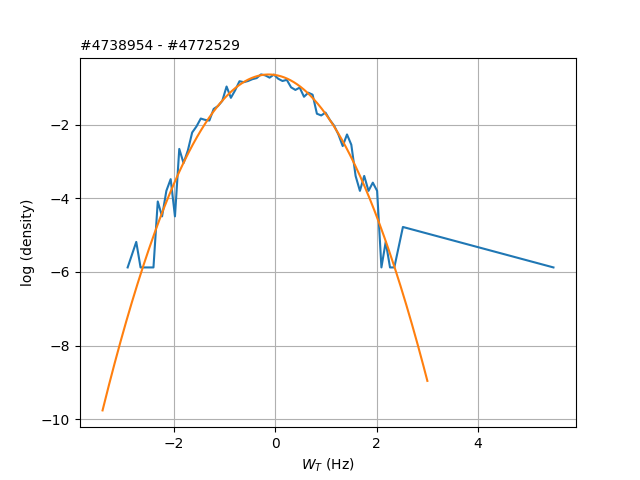

average =  -0.20466292031151762
stdev =  0.8023194277062268
sterr =  0.01238448136264083
100


In [123]:
to_hist = unumpy.nominal_values(W_T_b[start_mask])
to_hist_avg = np.average(to_hist)
to_hist_std = np.std(to_hist)

fig, ax = plt.subplots()

hist, bin_edges = np.histogram(to_hist, bins = 100, density = True)
bin_centers = bin_edges[:-1] + np.average(np.diff(bin_edges))  
log_density = np.log(hist)
bad_indices = np.argwhere(log_density == -np.inf)
log_density_clean = np.delete(log_density, bad_indices)
bin_centers_clean = np.delete(bin_centers, bad_indices)

bins_positive_edge = to_hist_avg + 3 * to_hist_std
bins_negative_edge = to_hist_avg - 3 * to_hist_std
bins_too_low = np.argwhere( bin_centers_clean < bins_negative_edge)
bins_too_large = np.argwhere( bin_centers_clean > bins_positive_edge)
bins_to_ignore = np.concatenate((bins_too_low, bins_too_large), axis = 0)

bins_to_fit = np.delete(bin_centers_clean, bins_to_ignore)
log_density_to_fit = np.delete(log_density_clean, bins_to_ignore)

ax.plot(bin_centers_clean, log_density_clean)

fitter = Fitter(parabola)
fitter.set_data(bins_to_fit, log_density_to_fit)
fitter.set_p0({"a": -0.5 / to_hist_std**2,
               "b": 0.5 * to_hist_avg /to_hist_std**2,
               "c": -0.5* to_hist_avg**2 / to_hist_avg**2
              })
fitter.fit()
#sigma = np.sqrt(-0.5 / fitter.results["a"])
# m

xaxis = np.linspace(to_hist_avg-4*to_hist_std,to_hist_avg+4*to_hist_std,400)
ax.plot(xaxis, fitter.fitted_value(xaxis))

ax.grid()
ax.set_xlabel("$W_T$ (Hz)")
ax.set_ylabel("log (density)")
ax.text(0, 1.02, f'#{data_range[0]} - #{max}', transform = ax.transAxes)
#ax.text(0.05,0.7, f"mean = {round(to_hist_avg, 3)} Hz \n stdev = {round(to_hist_std, 3)} Hz \n  sterr = {round(to_hist_std/np.sqrt(Ncycle), 3)} Hz", transform = ax.transAxes)

plt.show()
print("average = ", to_hist_avg)
print("stdev = ", to_hist_std)
print("sterr = ", to_hist_std/np.sqrt(Ncycle))
print(len(bin_centers))

Cannot plot  $f_b (D=+1, E=-1)$
Cannot plot  $f_b (D=-1, E=-1)$
Cannot plot  $\Delta f_b (D=\pm1, E=-1)$


/tmp/ipykernel_3171795/1354815446.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  step_sizes = [total_time / len(kk[1]) for kk in allan_variables]


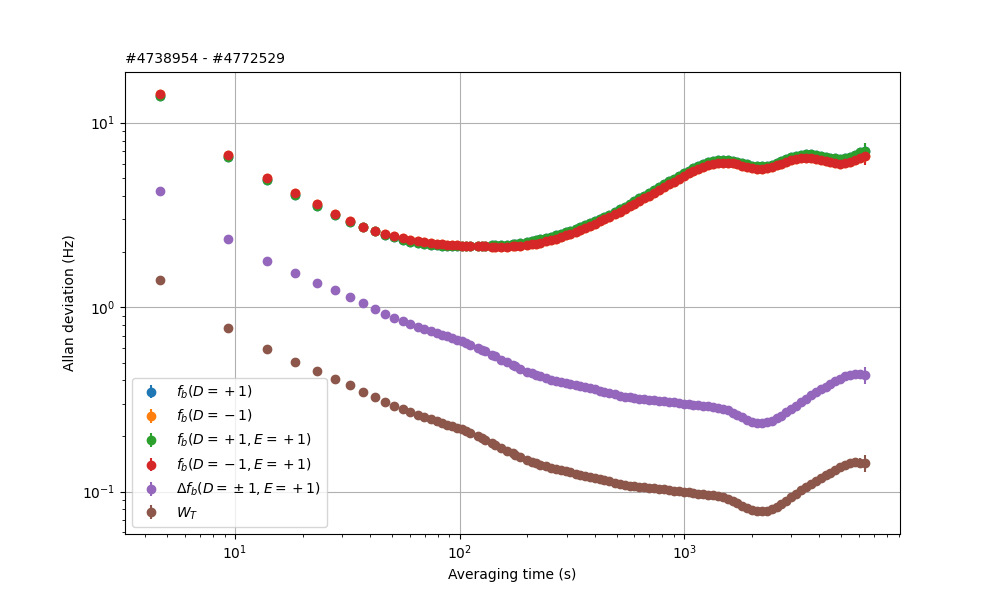

In [100]:
times = results[:, col_indices["start_time"]].astype(float)
taus = np.logspace(0, np.log10(len(times)) * 3, 500)
total_time = times[-1] - times[0]

allan_variables = [
    ("$f_b (D=+1)$", unumpy.nominal_values(results[:, col_indices["f+"]])),
    ("$f_b (D=-1)$", unumpy.nominal_values(results[:, col_indices["f-"]])),
    ("$f_b (D=+1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f+"]])),
    ("$f_b (D=-1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f-"]])),
    ("$f_b (D=+1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f+"]])),
    ("$f_b (D=-1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f-"]])),
    (
        "$\\Delta f_b (D=\\pm1, E=+1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == True, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == True, col_indices["f-"]]
        )
    ),
    (
        "$\\Delta f_b (D=\\pm1, E=-1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == False, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == False, col_indices["f-"]]
        )
    ),
    ("$W_T$", unumpy.nominal_values(results[:, col_indices["W_T"]])),
]
step_sizes = [total_time / len(kk[1]) for kk in allan_variables]

fig, ax = plt.subplots(figsize=(10, 6))
for kk, (label, variable) in enumerate(allan_variables):
    try:
        real_taus, allan, allan_err, _ = mdev(variable, data_type="freq", taus=taus)
        real_taus *= step_sizes[kk]
        ax.errorbar(real_taus, allan, allan_err, label=label, ls="none", fmt="o")
    except:
        print("Cannot plot ", label)
        continue
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()
ax.set_xlabel("Averaging time (s)")
ax.set_ylabel("Allan deviation (Hz)")
ax.text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax.transAxes)
plt.show()

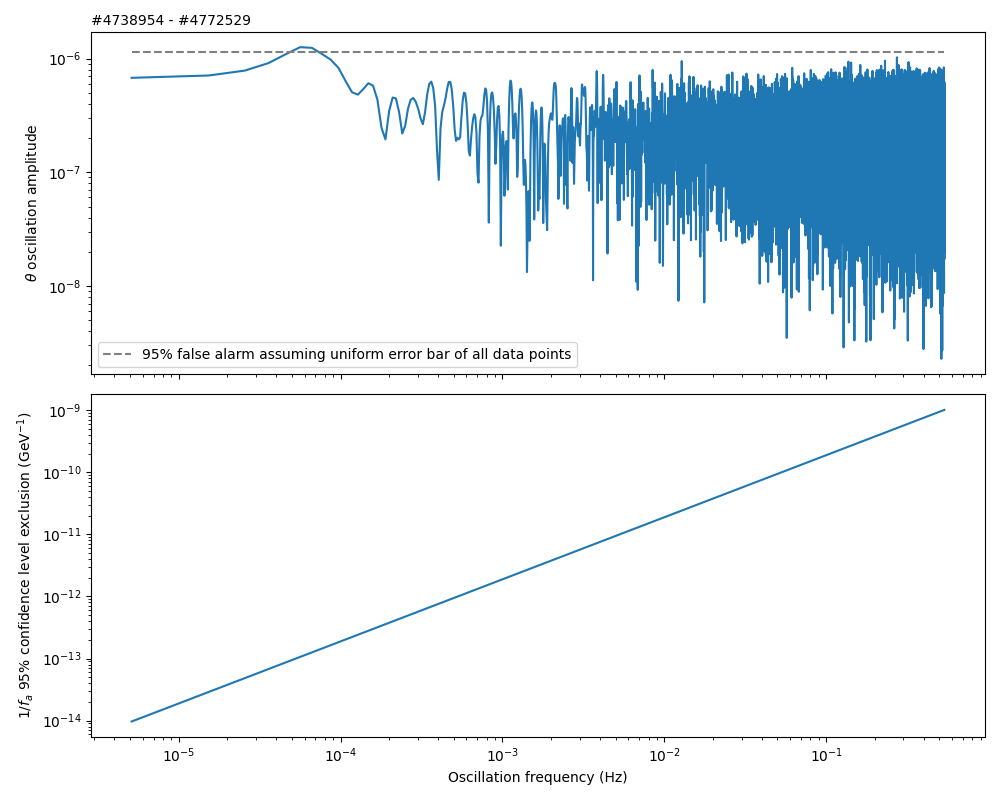

In [101]:
W_T_to_theta = 2.5e-5
# https://electricatoms.wordpress.com/2024/07/11/t-violation-measurement-from-lf-spectroscopy/
thetas = unumpy.nominal_values(results[:, col_indices["W_T"]])[start_mask] * W_T_to_theta
times = results[:, col_indices["start_time"]].astype(float)[start_mask]

theta_uncs = np.std(thetas) * np.ones(len(thetas))  # assuming error bar is std of the data for every point
ls = LombScargle(times, thetas, theta_uncs, normalization="psd")
fs, f_thetas_psd = ls.autopower()
f_thetas_amplitude_normalized = np.sqrt(f_thetas_psd / (len(f_thetas_psd) / 4))
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
f_thetas_amplitude = f_thetas_amplitude_normalized * np.std(thetas)
# https://docs.astropy.org/en/stable/timeseries/lombscargle.html#psd-normalization-unnormalized

confidence = 0.95
f_thetas_limit_psd = ls.false_alarm_level(1 - confidence)
f_thetas_limit_amplitude = np.sqrt(f_thetas_limit_psd / (len(f_thetas_psd) / 4)) * np.std(thetas)
# same normalization as above

inverse_fa_limits = inverse_fa_limit(fs, f_thetas_limit_amplitude * np.ones(len(fs)))

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(fs, f_thetas_amplitude)
ax[0].hlines([f_thetas_limit_amplitude], np.min(fs), np.max(fs), color="gray", ls="--", label=f"{confidence*100:.0f}% false alarm assuming uniform error bar of all data points")
ax[0].set_ylabel("$\\theta$ oscillation amplitude")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax[0].transAxes)
ax[0].legend()

ax[1].plot(fs, inverse_fa_limits)
ax[1].set_xlabel("Oscillation frequency (Hz)")
ax[1].set_ylabel(f"$1 / f_a$ {confidence*100:.0f}% confidence level" + " exclusion (GeV$^{-1}$)")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
plt.tight_layout()
plt.show()


In [102]:
times = (results[:, col_indices["start_time"]][start_mask][1:] - results[:, col_indices["start_time"]][start_mask][:-1])

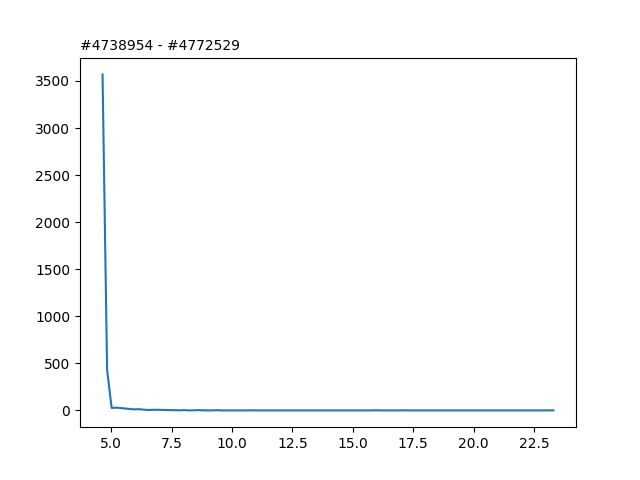

In [103]:
hist, x = np.histogram(times, bins=100)
fig, ax = plt.subplots()
ax.plot(x[1:], hist)
ax.text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax.transAxes)
plt.show()